In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

import lightgbm as lgb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from functools import reduce
import joblib


%matplotlib inline
pd.set_option("display.max_columns", None)
%config IPCompleter.greedy = True

In [15]:
route = pd.read_pickle("./route_14__.pkl")
bank_holidays = pd.read_pickle("./bank_holidays__.pkl")
weather = pd.read_pickle("./weather__.pkl")

In [16]:
route

,DayOfService,TripID,LineID,RouteID,ProgrNumber,StopPointID,Direction,PlannedTime_Dep,PlannedTime_Arr,ActualTime_Dep,ActualTime_Arr,LastUpdate
0,01-JAN-18 00:00:00,5957977,14,14_16,42,1353,2,37129,33600,35105,35105,08-JAN-18 17:21:10
1,01-JAN-18 00:00:00,5970398,14,14_16,42,1353,2,60472,55800,57731,57720,08-JAN-18 17:21:10
2,01-JAN-18 00:00:00,5965245,14,14_16,42,1353,2,62272,57600,59787,59787,08-JAN-18 17:21:10
3,01-JAN-18 00:00:00,5965247,14,14_16,42,1353,2,72577,68400,70337,70322,08-JAN-18 17:21:10
4,01-JAN-18 00:00:00,5959637,14,14_16,42,1353,2,74377,70200,72113,72104,08-JAN-18 17:21:10
...,...,...,...,...,...,...,...,...,...,...,...,...
2678405,31-DEC-18 00:00:00,8581163,14,14_16,72,244,2,39871,36000,39746,39746,16-JAN-19 18:27:21
2678406,31-DEC-18 00:00:00,8589342,14,14_16,72,244,2,27017,24300,27035,27035,16-JAN-19 18:27:21
2678407,31-DEC-18 00:00:00,8584102,14,14_16,72,244,2,27917,25200,28301,28301,16-JAN-19 18:27:21
2678408,31-DEC-18 00:00:00,8581161,14,14_16,72,244,2,28817,26100,29251,29251,16-JAN-19 18:27:21


In [17]:
weather.head()

,city_name,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon,date,hour
0,Dublin,53.349805,-6.26031,4.15,-6.49,3.84,5.79,990,,,87,12.86,240,40,520,Rain,light intensity shower rain,09n,2018-01-01,0
1,Dublin,53.349805,-6.26031,3.71,-2.28,3.00,5.80,1008,,,75,5.66,240,40,802,Clouds,scattered clouds,03n,2018-01-02,0
2,Dublin,53.349805,-6.26031,5.18,-3.85,5.00,6.66,985,,,87,10.80,260,75,520,Rain,light intensity shower rain,09n,2018-01-03,0
3,Dublin,53.349805,-6.26031,6.06,0.07,5.31,7.29,996,,,87,6.69,230,75,803,Clouds,broken clouds,04n,2018-01-04,0
4,Dublin,53.349805,-6.26031,4.09,-0.08,3.24,5.68,990,,,87,3.60,220,75,803,Clouds,broken clouds,04n,2018-01-05,0


In [18]:
def route_time_process(df):
    df['hour'] = (df['ActualTime_Arr']//3600) % 24
    return df
route =route_time_process(route)

In [19]:
def convert_2_datetime(df, col):
    df[col] = pd.to_datetime(df[col]) 
    return df
route = convert_2_datetime(route, 'DayOfService')
bank_holidays = convert_2_datetime(bank_holidays, 'date')
weather = convert_2_datetime(weather, 'date')

In [20]:
def add_bank_holiday(df, col, bank_holidays, date_col):
    df['bank_holiday'] = np.where(df[col].astype(str).isin(set(list(bank_holidays[date_col].astype(str)))),1,0)
    return df
route = add_bank_holiday(route, 'DayOfService', bank_holidays, 'date')

In [21]:
len(route[route['bank_holiday'] == 1])

38462

In [47]:
col = ['hour', 'StopPointID', 'ProgrNumber','temp',
       'day_of_week','day_of_year', 'journey_time']

def merge_and_clean(df1, df2, col):
    combined_df = pd.merge(df1, df2,  how='inner', left_on=['DayOfService', 'hour'], 
                           right_on = ['date', 'hour'],
                           suffixes=('_route','_weather'))
#     combined_df['Direction'] = combined_df['Direction'].astype('int')
    combined_df['day_of_week'] = combined_df['DayOfService'].dt.dayofweek
    combined_df['day_of_year'] = combined_df['DayOfService'].dt.dayofyear
    combined_df['journey_time'] = combined_df['ActualTime_Dep'] - combined_df['PlannedTime_Arr']
    combined_df['journey_time'] = combined_df['journey_time'].apply(lambda x: x if x > 0 else 0)
    combined_df['StopPointID'] = combined_df['StopPointID'].astype('category')
    combined_df['weather_main'] = combined_df['weather_main'].astype('category')
    combined_df = combined_df[col]
    return combined_df
df = merge_and_clean(route, weather, col)

In [48]:
df.shape

(2678410, 7)

In [49]:
# fig, ax = plt.subplots(figsize=(24,6))
# ax = sns.countplot(x="weather_main", data=df)
# plt.xticks(rotation=45)

In [50]:
def one_hot_encoding(df, col_list):
    df = pd.get_dummies(df, prefix = col_list, columns = col_list)
    return df

In [51]:
def remove_outlier(df):    
    df = df[np.abs(df["journey_time"]-df["journey_time"].mean())<=(1.5*df["journey_time"].std())]
    return df

In [52]:
# df = one_hot_encoding(df, ['StopPointID'])
print ("Shape Of The Before Ouliers: ",df.shape)
df = remove_outlier(df)
print ("Shape Of The After Ouliers: ",df.shape)

Shape Of The Before Ouliers:  (2678410, 7)
Shape Of The After Ouliers:  (2461614, 7)


In [53]:
# fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,16))
# # sns.boxplot(data=df,y="journey_time",x="bank_holiday",orient="v",ax=axes[0][0])
# sns.boxplot(data=df,y="journey_time",x="day_of_week",orient="v",ax=axes[0][1])
# sns.boxplot(data=df,y="journey_time",x="day_of_year",orient="v",ax=axes[1][0])
# sns.boxplot(data=df,y="journey_time",x="hour",orient="v",ax=axes[1][1])
# # axes[0][0].set(ylabel='bank_holiday')
# axes[0][1].set(xlabel='day_of_week', ylabel='journey_time')
# axes[1][0].set(xlabel='day_of_year', ylabel='journey_time')
# axes[1][1].set(xlabel='hour', ylabel='journey_time')

In [54]:
# # # Slow runnimg

# # Finding distribution between different time
# fig, axes = plt.subplots(ncols=2, figsize=(16,6))
# sns.barplot(data=df, y = 'journey_time', x = 'hour', ax=axes[0])
# sns.barplot(data=df, y = 'journey_time', x = 'day_of_week', ax=axes[1])

In [55]:
# #Finding correlation of continuous features
# col = ['hour',
#        'temp', 'pressure', 'wind_speed',
#        'day_of_week', 'day_of_year', 'journey_time']
# corrMatt = df[col].corr()
# mask = np.array(corrMatt)
# mask[np.tril_indices_from(mask)] = False
# fig,ax= plt.subplots(figsize=(16,12))
# sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
# plt.show()

In [56]:
# fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(16,12))
# sns.distplot(df["temp"],ax=axes[0][0])
# sns.distplot(df["pressure"],ax=axes[0][1])
# # sns.distplot(df["humidity"],ax=axes[1][0])
# sns.distplot(df["wind_speed"],ax=axes[1][1])
# # sns.distplot(df["clouds_all"],ax=axes[2][0])
# sns.distplot(df["journey_time"],ax=axes[2][1])

# axes[0][0].set(xlabel='temp', ylabel='d')
# axes[0][1].set(xlabel='pressure', ylabel='d')
# # axes[1][0].set(xlabel='humidity', ylabel='d')
# axes[1][1].set(xlabel='wind_speed', ylabel='d')
# # axes[2][0].set(xlabel='clouds_all', ylabel='d')
# axes[2][1].set(xlabel='journey_time', ylabel='d')

In [57]:
def time_transform(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    df = df.drop([col], axis = 1)
    return df

In [58]:
df = time_transform(df, 'day_of_week', 7)
df = time_transform(df, 'hour', 24)

In [59]:
y = df['journey_time']
x = df.loc[:, df.columns != 'journey_time']

In [60]:
y_avg = y.mean()
y_avg

2296.646866243042

In [61]:
size = len(x) * 9 //10 
x_train, x_test = x[:size], x[size:]
y_train, y_test = y[:size], y[size:]
print(size)

2215452


In [62]:
x_train.dtypes

StopPointID        category
ProgrNumber           int64
temp                float64
day_of_year           int64
day_of_week_sin     float64
day_of_week_cos     float64
hour_sin            float64
hour_cos            float64
dtype: object

In [63]:
%%time
#Model validation
lgb_turned = lgb.LGBMRegressor()
lgb_turned.fit(x_train, y_train, categorical_feature=['StopPointID'])
scores_rmse=cross_val_score(lgb_turned, x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
scores_mae=cross_val_score(lgb_turned, x_train, y_train, scoring='neg_mean_absolute_error', cv=5)
print("- RMSE: {:.5f}".format(np.mean(scores_rmse)))
print("- MAE: {:.5f}".format(np.mean(scores_mae)))

/Users/pie_trick/Desktop/Semester3/venv/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['StopPointID']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


- RMSE: -308.28551
- MAE: -220.96200
CPU times: user 5min 40s, sys: 7.22 s, total: 5min 47s
Wall time: 52.4 s


In [64]:
from sklearn.dummy import DummyRegressor
dummy = DummyRegressor()
dummy.fit(x_train, y_train)
scores_rmse=cross_val_score(dummy, x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
scores_mae=cross_val_score(dummy, x_train, y_train, scoring='neg_mean_absolute_error', cv=5)
print("- RMSE: {:.5f}".format(np.mean(scores_rmse)))
print("- MAE: {:.5f}".format(np.mean(scores_mae)))

- RMSE: -1440.02975
- MAE: -1281.51948


In [65]:
model_name = 'route_116__lgbm_model.pkl'
joblib.dump(lgb_turned, model_name)

['route_116__lgbm_model.pkl']

In [66]:
%%time
model = joblib.load(model_name)
y_prediction = model.predict(x_test)

CPU times: user 2.5 s, sys: 28.3 ms, total: 2.53 s
Wall time: 338 ms


In [67]:
y_test = y_test.reset_index()["journey_time"]
metrics.mean_absolute_error(y_test, y_prediction)

259.1488376710884

In [68]:
_prediction = pd.Series(y_prediction)

In [69]:
x_test

,StopPointID,ProgrNumber,temp,day_of_year,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
2407146,1054,21,12.99,332,0.974928,-0.222521,-0.5,-0.866025
2407147,4709,23,12.99,332,0.974928,-0.222521,-0.5,-0.866025
2407148,1037,24,12.99,332,0.974928,-0.222521,-0.5,-0.866025
2407149,1038,25,12.99,332,0.974928,-0.222521,-0.5,-0.866025
2407150,2998,26,12.99,332,0.974928,-0.222521,-0.5,-0.866025
...,...,...,...,...,...,...,...,...
2678404,2856,64,9.19,365,0.000000,1.000000,-0.5,0.866025
2678405,2856,64,9.19,365,0.000000,1.000000,-0.5,0.866025
2678406,496,48,9.19,365,0.000000,1.000000,-0.5,0.866025
2678407,242,70,9.19,365,0.000000,1.000000,-0.5,0.866025


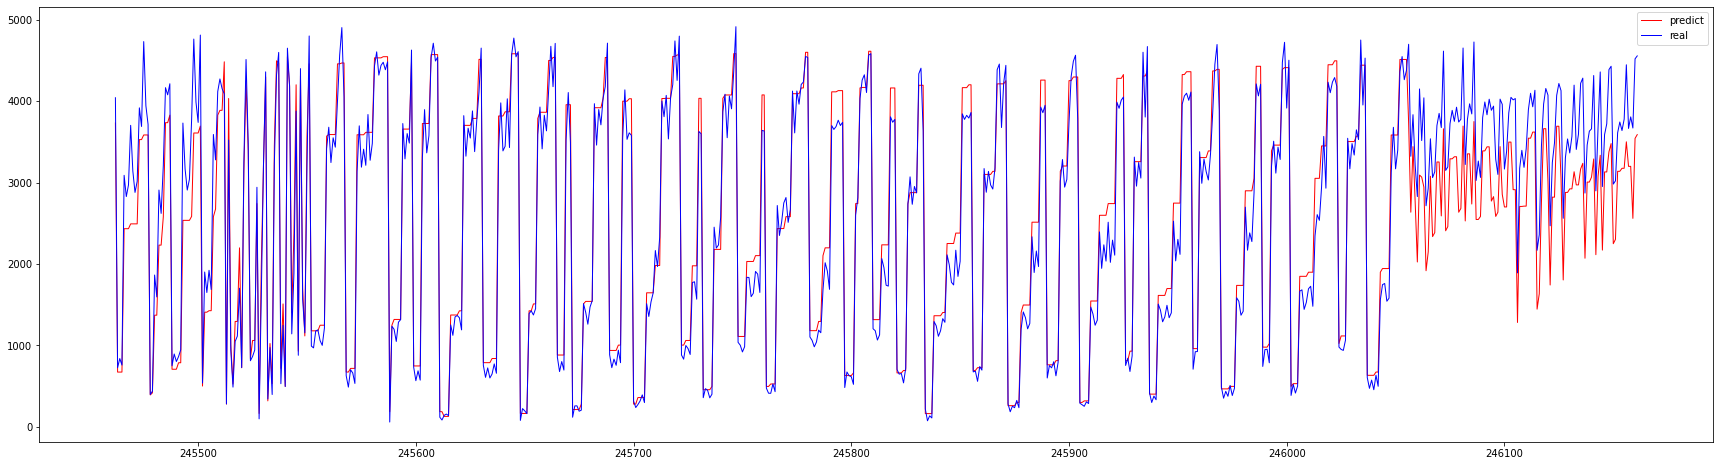

In [70]:
fig, ax = plt.subplots(figsize=(30,8))
plt.plot(_prediction[-700:], linewidth=1, color = 'red', label = 'predict')
plt.plot(y_test[-700:], linewidth=1, color = 'blue', label = 'real')
plt.legend()
plt.show()

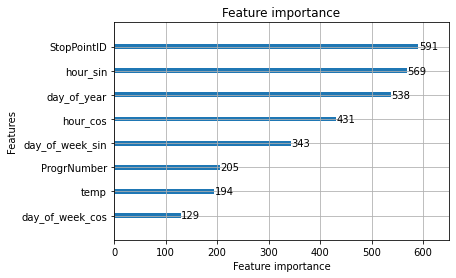

In [71]:
lgb.plot_importance(model)

In [54]:
"Thomas Street, stop 1938".split(',')[0]

'Thomas Street'

In [55]:
# x = pd.read_csv('routesstops.csv')

In [56]:
# routesstops_cache = dict()
# for index, row in x.iterrows():
#     routesstops_cache[(row['route'].strip(), row['stop_name'].strip())] = row['stopid']

In [57]:
# import pprint
# pd.options.display.max_rows = 100000
# pprint.pprint(routesstops_cache)

{('1', 'Bath Street'): 391,
 ('1', 'Botanic Avenue'): 46,
 ('1', "DCU St Patrick's"): 45,
 ('1', 'DCU St Patrick‚Äôs'): 7602,
 ('1', 'Dargle Road'): 18,
 ('1', 'Dorset Street Lower'): 49,
 ('1', 'Dorset Street Upper'): 52,
 ('1', 'Dromard Terrace'): 375,
 ('1', 'Drumcondra Rail Stn'): 47,
 ('1', 'Ellenfield Park'): 1641,
 ('1', 'Erne Street'): 398,
 ('1', 'Farney Park'): 388,
 ('1', 'Fitzroy Avenue'): 48,
 ('1', 'Gilford Road'): 383,
 ('1', 'Grand Canal Quay'): 396,
 ('1', 'Griffith Downs'): 4432,
 ('1', 'Highfield Hospital'): 214,
 ('1', 'Innisfallen Parade'): 15,
 ('1', 'Irishtown Road'): 371,
 ('1', 'Iveragh Road'): 213,
 ('1', 'Lea Road'): 384,
 ('1', 'Newgrove Avenue'): 385,
 ('1', "O'Connell St Lower"): 271,
 ('1', "O'Connell St Upper"): 278,
 ('1', 'Oldtown Road'): 229,
 ('1', 'Parnell Square East'): 265,
 ('1', 'Parnell Square West'): 10,
 ('1', 'Pearse Square'): 397,
 ('1', 'Pearse Station'): 399,
 ('1', "Prince's St South"): 350,
 ('1', 'Ringsend'): 392,
 ('1', 'Ringsend Gara

 ('140', 'Prospect Hill'): 1532,
 ('140', 'Rathmines'): 1070,
 ('140', 'Rathmines Close'): 1067,
 ('140', 'Rathmines Rd Lower'): 1017,
 ('140', 'Rathmines Rd Upper'): 1021,
 ('140', "Redmond's Hill"): 7579,
 ('140', "S Great George's St"): 1283,
 ('140', 'Seagrave Terrace'): 6276,
 ('140', 'Slaney Road'): 1509,
 ('140', 'South Richmond St'): 1072,
 ('140', "St Margaret's Road"): 7277,
 ('140', "St Mary's College"): 1071,
 ('140', "St Vincent's School"): 1537,
 ('140', 'Summerville Park'): 1022,
 ('140', 'Swan Centre'): 1076,
 ('140', 'The Spire of Dublin'): 6059,
 ('140', 'The Willows'): 1535,
 ('140', 'Tolka Vale'): 1533,
 ('140', 'Wellmount Road'): 4543,
 ('140', 'Western Way'): 194,
 ('140', 'Westmoreland Street'): 319,
 ('142', 'Adelaide Road'): 1015,
 ('142', 'Aungier Street'): 1354,
 ('142', 'Beckett Bridge'): 2500,
 ('142', 'Bird Avenue'): 3012,
 ('142', 'Blackwood Lane'): 7327,
 ('142', 'Br an Phoirt Thoir'): 7623,
 ('142', 'Chamley Park'): 7692,
 ('142', 'Church Avenue'): 6042

 ('15d', 'Butterfield Park'): 7066,
 ('15d', 'Camden Street Lower'): 1285,
 ('15d', 'Charleville Square'): 5131,
 ('15d', 'Crannagh Road'): 1332,
 ('15d', 'Dame Street'): 7582,
 ('15d', 'Dodder Bridge'): 1334,
 ('15d', 'Dodder Park Road'): 1301,
 ('15d', 'Erne Street'): 398,
 ('15d', 'Everton Hall'): 2924,
 ('15d', 'Fade Street'): 7578,
 ('15d', 'Frankfort Avenue'): 1079,
 ('15d', 'Garville Avenue'): 1167,
 ('15d', 'Glenmore Park'): 2956,
 ('15d', 'Grand Canal Quay'): 396,
 ('15d', 'Grantham Street'): 7577,
 ('15d', 'Grove Park'): 4528,
 ('15d', 'Hillside Park'): 2942,
 ('15d', 'Marian Crescent'): 1137,
 ('15d', 'Marian Road'): 1135,
 ('15d', 'Meadowbank'): 2986,
 ('15d', 'Military Road'): 1019,
 ('15d', 'Moyville Lawns'): 2984,
 ('15d', 'Orwell Mews'): 3001,
 ('15d', 'Orwell Road'): 2914,
 ('15d', 'Owendore Avenue'): 5132,
 ('15d', 'Pearse Brothers Park'): 2983,
 ('15d', 'Pearse Square'): 397,
 ('15d', 'Pearse Station'): 399,
 ('15d', 'Pleasants Street'): 1353,
 ('15d', "Prince's St S

 ('27a', 'Malahide Road'): 669,
 ('27a', 'Marino College'): 523,
 ('27a', 'Marino Crescent Park'): 668,
 ('27a', 'Mask Crescent'): 1799,
 ('27a', 'Mayfield Park'): 1221,
 ('27a', 'McAuley Drive'): 1797,
 ('27a', 'McAuley Park'): 1796,
 ('27a', 'McAuley Road'): 1798,
 ('27a', 'Milbrook Grove'): 1793,
 ('27a', 'Millbrook Road'): 1792,
 ('27a', 'Millwood Villas'): 961,
 ('27a', 'Mornington Grove'): 1277,
 ('27a', 'Mount Temple School'): 670,
 ('27a', 'Naomh Barr??g GAA'): 956,
 ('27a', 'Nazareth House'): 671,
 ('27a', 'Newcomen Bridge'): 618,
 ('27a', 'North Strand Road'): 519,
 ('27a', 'Nth Strand Fire Stn'): 616,
 ('27a', "O'Tooles GAA"): 7199,
 ('27a', 'Portland Row'): 515,
 ('27a', 'Ribh Road'): 645,
 ('27a', 'Springdale Road'): 637,
 ('27a', 'St Josephs Hospital'): 643,
 ('27a', "St. Donagh's"): 958,
 ('27a', 'Strandville Avenue'): 617,
 ('27a', 'Talbot Street'): 620,
 ('27a', 'Tonlegee Avenue'): 634,
 ('27a', 'Tonlegee Drive'): 633,
 ('27a', 'Tonlegee Road'): 960,
 ('27b', 'Amiens S

 ('33', 'Rush Cricket Club'): 3835,
 ('33', 'Rush Garda Station'): 3840,
 ('33', 'Rush Main Street'): 3837,
 ('33', 'Rush Road'): 3565,
 ('33', 'Rush Station'): 3770,
 ('33', 'Santry Close'): 1637,
 ('33', 'Santry Retail Park'): 1627,
 ('33', 'Schoolhouse Lane'): 1639,
 ('33', 'Seatown Villas'): 3752,
 ('33', 'Selskar Court'): 3571,
 ('33', 'Selskar Road'): 3569,
 ('33', 'Shanowen Road'): 1622,
 ('33', 'Shanvarna Road Est'): 231,
 ('33', 'Shenick Road'): 3824,
 ('33', 'Skerries'): 3819,
 ('33', 'Skerries GAA Club'): 7292,
 ('33', 'Skerries RFC'): 3823,
 ('33', 'Skerries Road'): 3781,
 ('33', 'Skerries Station'): 6077,
 ('33', 'Skylon Hotel'): 44,
 ('33', 'Spout Road'): 3846,
 ('33', "St Maur's Church"): 3777,
 ('33', "St Patrick's College"): 7603,
 ('33', 'Station Road'): 3854,
 ('33', 'Stockhole Lane'): 3699,
 ('33', 'Strand Street'): 3820,
 ('33', 'Swords Castle'): 3711,
 ('33', 'Swords Main Street'): 3691,
 ('33', 'Swords Road'): 5053,
 ('33', 'Temple Street'): 51,
 ('33', 'The Stra

 ('39x', 'Morgan Place'): 1845,
 ('39x', 'National Gallery'): 7586,
 ('39x', 'Old Cabra Road'): 1906,
 ('39x', 'Ongar'): 7700,
 ('39x', 'Ongar Square'): 7160,
 ('39x', 'Pearse Station'): 2809,
 ('39x', 'Pembroke St Lower'): 785,
 ('39x', 'Phibblestown Road'): 7017,
 ('39x', 'Prussia Street'): 1911,
 ('39x', 'Ravenwood Road'): 7030,
 ('39x', 'Science Gallery'): 7587,
 ('39x', 'Stonebridge Road'): 6112,
 ('4', 'Albert College Court'): 90,
 ('4', 'Albert College Park'): 29,
 ('4', 'American Embassy'): 487,
 ('4', 'Ballymun Library'): 92,
 ('4', 'Ballymun Road'): 27,
 ('4', 'Ballymun Road Church'): 115,
 ('4', 'Ballymun Road NS'): 91,
 ('4', 'Bellevue Avenue'): 475,
 ('4', 'Blackrock Clinic'): 470,
 ('4', 'Blackrock College'): 471,
 ('4', 'Blessington Street'): 819,
 ('4', 'Bluepool Pitches'): 7330,
 ('4', 'Booterstown Station'): 472,
 ('4', 'Botanic Road'): 201,
 ('4', 'British Embassy'): 483,
 ('4', 'Broadstone'): 195,
 ('4', 'Civic Centre'): 94,
 ('4', 'Clare Street'): 494,
 ('4', 'DCU'

 ('42', 'Connolly'): 497,
 ('42', 'Coolock Leisureplex'): 1273,
 ('42', 'Copperbush'): 3661,
 ('42', 'Cricket Club'): 3635,
 ('42', 'Danieli Road'): 1219,
 ('42', 'Donnycarney Church'): 664,
 ('42', 'Donnycarney Road'): 672,
 ('42', 'Elm Mount Road'): 1196,
 ('42', 'Estuary Road'): 4339,
 ('42', 'Fairview'): 614,
 ('42', 'Fingal Cemetery'): 1216,
 ('42', 'Hill Drive'): 3632,
 ('42', 'Kelvin Close'): 3606,
 ('42', 'Kileen Park'): 5081,
 ('42', 'Killester Avenue'): 1220,
 ('42', 'Kinsealy School'): 1212,
 ('42', 'Malahide Castle'): 3640,
 ('42', 'Malahide Comm School'): 3630,
 ('42', 'Malahide Demense'): 3644,
 ('42', 'Malahide Golf Club'): 6053,
 ('42', 'Malahide Road'): 669,
 ('42', 'Malahide Station'): 3634,
 ('42', 'Marino College'): 523,
 ('42', 'Marino Crescent Park'): 668,
 ('42', 'Mask Avenue'): 1275,
 ('42', 'Mask Park'): 1276,
 ('42', 'Mayfield Park'): 1221,
 ('42', 'Millview'): 5082,
 ('42', 'Moland Street'): 1184,
 ('42', 'Mornington Grove'): 1277,
 ('42', 'Mount Temple Schoo

 ('54a', "Harold's Cross Road"): 1291,
 ('54a', 'IT Tallaght'): 4436,
 ('54a', 'Killinarden Estate'): 2571,
 ('54a', 'Kimmage Grove'): 2441,
 ('54a', 'Kimmage Road Lower'): 2438,
 ('54a', 'Lavarna'): 2412,
 ('54a', 'Le Vere Terrace'): 1345,
 ('54a', 'Lifegate Church'): 2594,
 ('54a', 'Limekiln Drive'): 1111,
 ('54a', 'Lombard Street West'): 2635,
 ('54a', 'Long Lane'): 2387,
 ('54a', 'Maplewood Avenue'): 2359,
 ('54a', 'Marlfield'): 5161,
 ('54a', 'Marlfield Drive'): 5024,
 ('54a', 'Mount Argus Church'): 2442,
 ('54a', 'Mount Argus Park'): 2390,
 ('54a', 'Mount Argus Road'): 2444,
 ('54a', 'New Street South'): 2636,
 ('54a', 'Osprey Road'): 1100,
 ('54a', 'Patrick Street'): 2385,
 ('54a', "Patrick's Cathedral"): 2383,
 ('54a', 'Poddle Park'): 2394,
 ('54a', 'Ravensdale Park'): 2439,
 ('54a', 'Rossmore Drive'): 6132,
 ('54a', 'South Dublin CC'): 4647,
 ('54a', 'Spawell Centre'): 2599,
 ('54a', "St Claire's NS"): 1344,
 ('54a', "St Clare's Avenue"): 2389,
 ('54a', "St Jude's GAA Club"): 

 ('66x', 'Palmerstown Drive'): 2201,
 ('66x', 'Pearse St Garda Stn'): 345,
 ('66x', 'Pearse Station'): 2809,
 ('66x', 'Pembroke St Lower'): 785,
 ('66x', 'RTE'): 770,
 ('66x', 'River Forest'): 3995,
 ('66x', 'Royal Hospital'): 777,
 ('66x', 'Ryevale Lawns'): 3990,
 ('66x', 'Salmon Leap'): 3956,
 ('66x', 'Sarsfield Quay'): 1476,
 ('66x', 'Science Gallery'): 7587,
 ('66x', 'Scoil Bhride'): 6161,
 ('66x', 'Springfield Hotel'): 4000,
 ('66x', "St Loman's Hospital"): 2215,
 ('66x', "St Mary's Church"): 3958,
 ('66x', "Stephen's Green Nth"): 791,
 ('66x', 'Straffan Road'): 3918,
 ('66x', "Tandy's Lane"): 7193,
 ('66x', 'Teresian School'): 771,
 ('66x', 'The Oval'): 2242,
 ('66x', 'UCD'): 4952,
 ('66x', 'UCD N11 Entrance'): 768,
 ('66x', "Usher's Quay"): 1445,
 ('66x', 'Vesey Park'): 7049,
 ('66x', 'Victoria Avenue'): 758,
 ('66x', 'Victoria Quay'): 1447,
 ('66x', 'Waterloo Road'): 779,
 ('66x', 'Wellington Lane'): 755,
 ('66x', 'Wellington Quay'): 312,
 ('66x', 'Westmoreland Street'): 318,
 

 ('77a', 'Ardee Street'): 2380,
 ('77a', 'Avonmore Drive'): 2609,
 ('77a', 'Avonmore Park'): 2602,
 ('77a', 'Avonmore Road'): 2608,
 ('77a', 'Balfe Road'): 2102,
 ('77a', 'Belfry'): 4933,
 ('77a', 'Belfry Downs'): 2590,
 ('77a', 'Belgard Square North'): 5008,
 ('77a', 'Bianconi Avenue'): 7459,
 ('77a', 'Blessington Road'): 2351,
 ('77a', 'Bolbrook'): 2611,
 ('77a', 'Brickfield Lane'): 2315,
 ('77a', 'Calmount Avenue'): 2335,
 ('77a', 'Castle Drive'): 4714,
 ('77a', 'Castle Park'): 5133,
 ('77a', 'Castletymon Green'): 2424,
 ('77a', 'Castletymon Road'): 2425,
 ('77a', 'Citywest Avenue'): 4930,
 ('77a', 'Citywest Road'): 4960,
 ('77a', 'Citywest SC'): 7460,
 ('77a', 'College Green'): 4522,
 ('77a', 'Coombe Hospital'): 4434,
 ('77a', 'Corbally Vale'): 2575,
 ('77a', 'Cork Street'): 2314,
 ('77a', 'Crumlin College'): 2188,
 ('77a', 'Crumlin Hospital'): 2101,
 ('77a', 'Crumlin Road'): 2186,
 ('77a', 'Crumlin SC'): 2189,
 ('77a', 'Cushlawn Park'): 2560,
 ('77a', 'Dame Street'): 1934,
 ('77a'

 ('83a', 'Rathmines'): 1070,
 ('83a', 'Rathmines Garda Stn'): 1170,
 ('83a', 'Rathmines Rd Lower'): 1017,
 ('83a', "Redmond's Hill"): 1284,
 ('83a', 'Rockmount'): 1556,
 ('83a', "S Great George's St"): 1283,
 ('83a', 'Scoil Colm'): 2466,
 ('83a', 'Scoil Una Naofa'): 2450,
 ('83a', 'South Richmond St'): 1072,
 ('83a', "St Brigid's School"): 154,
 ('83a', "St Canice's BNS"): 138,
 ('83a', "St Margaret's Road"): 6219,
 ('83a', "St Mary's College"): 1071,
 ('83a', "St Michan's Church"): 1616,
 ('83a', "St Teresa's Place"): 185,
 ('83a', 'Stannaway Ave'): 2492,
 ('83a', 'Stannaway Road'): 2494,
 ('83a', 'Sundrive Park'): 2497,
 ('83a', 'Sundrive Road'): 2485,
 ('83a', 'Swan Centre'): 1076,
 ('83a', 'Sycamore Park'): 4890,
 ('83a', 'Sycamore Road'): 6273,
 ('83a', 'Tolka Estate'): 174,
 ('83a', 'Westfield Road'): 2474,
 ('83a', 'Westmoreland Street'): 319,
 ('83a', 'Whitefriars St'): 4456,
 ('83a', 'Whitefriars Street'): 1355,
 ('84', 'Beech Park Road'): 3155,
 ('84', 'Beechdale'): 4308,
 ('

In [73]:
a = "Dundrum, Main Street"
b = "Eden Quay, stop 297"
if "stop" in b:
    print("yes")
else:
    print("no")


yes


In [77]:
b.split('stop')[1].strip()

'297'